In [29]:
import numpy as np
import xbout
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

sys.path.append(r"C:\Users\mikek\OneDrive\Project\python-packages\sdtools")
from hermes3.load import *

In [145]:
# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw3d_base"
# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw8c_diff_1e-4"
path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw8cb_longer"
squash(path)
# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw3d_2_alpha2.14e5"
# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw6_kappa_6.81e-2_smallerdomain"
ds_original = xbout.load.open_boutdataset(
                datapath = os.path.join(path,"BOUT.squash.nc"),
                inputfilepath = os.path.join(path, "BOUT.inp"),
                info = False,
                cache = False,
                keep_xboundaries=False,
                keep_yboundaries=False,
                # keep_zboundaries=False
                )

- Looking for squash file
- Squashoutput file not found, creating...
- Done


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    bout_type:      Field2D
    metadata:       {'BOUT_VERSION': 5.01, 'MXG': 2, 'MXSUB': 8, 'MYG': 2, 'M...
    options:        #\n# Hasegawa-Wakatani test case\n#\n\ntimestep = 40   # ...
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


# Input calculation
The below was assumed based on rough SOL conditions in MAST-U:
- T_0 = 50 [eV]
- n_0 = 1e19 [m^-3]
- B = 0.5 [T]

We can then calculate the electron cyclotron frequency:
$$ \omega_{ce} = \frac{eB}{m_e} = 8.79e11 [s^{-1}]$$

We now need the nu_ei term. The notes are inconsistent: in the Parallel current section, nu_ei is referred to as a friction due to collisions with ions, which is also consistent with the variable name. Later, in the Normalisation section, it's referred to as the electron collision frequency.

For now we assume the former is correct.
We calculate the ee collision time and frequency from Fitzpatrick (https://farside.ph.utexas.edu/teaching/plasma/lectures1/node35.html).
Note that confusingly the notes refer to $\nu_{ei}$ as a resistivity, not a collision frequency. I use $freq$ to make the notation clearer.

$$\tau_{ee} = 1.22\times 10^{-6}$$
$$freq_{ee} = \frac{1}{\tau_{ei}} = 8.22 \times 10^{6} [s^{-1}]$$

Resistivity can be calculated as below (see any textbook with Braginskii parallel friction, thanks John Omotani):
$$ \nu_{ei} = freq_{ee} * 0.51 = 4.11 \times 10^{6} [s^{-1}] $$

Finally, we arrive at our parameter alpha:
$$ \alpha = \frac{\omega_{ce}}{\nu_{ei}} = 2.14 \times 10^{5} $$



# Calculation based on Chen and Anderson

In [116]:
### User set inputs
T0 = 50  # Plasma temperature [eV]
n0 = 1e19  # Plasma density [m^-3]
B = 0.5   # Magnetic field [T]
Z = 1

### Constants
Mp = 1.6726219e-27 # Proton mass [kg]
Mi = Mp*2  # Ion mass of deuterium [kg]
Me = 9.1093837e-31 # Electron mass [kg]
qe = 1.60217662E-19 # electron charge [C] or [J ev^-1]
e0 = 8.854187817e-12 # Vacuum permittivity [F m^-1]
kb = 1.38064852e-23 # Boltzmann constant [J K^-1]

### Normalisations
omega_ci = qe * B / Mi   # ion gyrofrequency [s^-1]
omega_ce = qe * B / Me   # electron gyrofrequency [s^-1]
Cs0 = np.sqrt( (qe * T0) / Mi)   # Speed [m s^-1]
rho_s0 = np.sqrt(Mi*T0/(qe*B))  # Distance, from hybrid Larmor radius [m]

## From Hermes-3 manual: 
# https://hermes3.readthedocs.io/en/latest/components.html#collisions
## Originally from NRL formulary but converted to SI from CGS, hence different constants:
# https://library.psfc.mit.edu/catalog/online_pubs/NRL_FORMULARY_19.pdf


if T0 < 0.1 or n0 < 1e10:
    clog = 10   
elif T0*Me/Mi < T0 and T0 < 10*Z**2:
    clog = 30 - 0.5*np.log(n0) + 1.5*np.log(T0)
elif T0*Me/Mi < 10*Z**2 and 10*Z**2 < T0:    # <--------- This one for T0=50, n0=1e19
    clog = 31 - 0.5*np.log(n0) + np.log(T0)
elif T0 < T0*Me/Mi:
    clog = 23 - 0.5*np.log(n0) + 1.5*np.log(T0) - np.log(Z*Mi)
        

# Collision time from Fitzpatrick https://farside.ph.utexas.edu/teaching/plasma/lectures1/node35.html
T0_celsius = T0 * qe / kb
T0_joules = T0 * qe

eta = (np.pi * qe**2 * np.sqrt(Me)) / (4 * np.pi * e0)**2 * (T0 * qe)**(3/2) * clog
eta_spitzer = 5.2e-5 * (Z*clog) / (T0**(3/2))  # T0 in eV

k = 1    # Parallel wavenumber, should be z-direction representative wavenumber (2pi/lpar)

alpha = (T0 * k**2) / (n0 * qe * eta_spitzer * omega_ci)
# alpha = omega_ci / eta_spitzer

print(f"Distance norm: {rho_s0:.2e}")
print(f"Coulomb log: {clog:.2f}")
print(f"omega_ce: {omega_ce:.2e}")
print(f"omega_ci: {omega_ci:.2e}")
print(f"electron resistivity eta: {eta:.2e}")
print(f"electron resistivity eta (spitzer): {eta_spitzer:.2e}")
print(f"alpha parameter: {alpha:.2e}")

Distance norm: 1.44e-03
Coulomb log: 13.04
omega_ce: 8.79e+10
omega_ci: 2.39e+07
electron resistivity eta: 1.84e-57
electron resistivity eta (spitzer): 1.92e-06
alpha parameter: 6.80e-01


## Calculating kappa
Kappa is defined like this in the notes:
$${\hat \kappa}=\dfrac{\rho_{e}}{n_{0}}\dfrac{\partial N}{\partial x}$$

We can get $\dfrac{\partial N}{\partial x}$ from the density decay scale length:
$$\dfrac{\partial N}{\partial x}=\dfrac{n_{0}}{\lambda_{N}}$$

For now let's assume that for MAST-U it's similar to its power width: $\lambda_{N} = \lambda_{q} = 30mm$. I only know the rough MAST-U $\lambda_{q}$



### Normalisation...
The 2D section of the notes says $\kappa$ is normalised to the electron gyro radius $\rho_{e}$, and $k_{\parallel}$ is normalised the same way.

This is not consistent with the 3D section where length is normalised to the ion gyro radius $\rho_{s0}$. I don't think we should have two different length normalisations, so I am assuming that the normalisations for 2D and 3D are different and that we should use $\rho_{s0}$.

So:
$${\hat \kappa} = \dfrac{\rho_{s0}}{\lambda_{N}}$$

In [117]:
kappa = rho_s0 / 0.015

print(f"Normalised kappa input is {kappa:.2e}")

Normalised kappa input is 9.63e-02


## A few words about vorticity
- Vorticity is described in Fundamenski 2007
- It's the vorticity of the electric drift
- It's defined as Omega = grad_P**2 phi
- I will fill this in with more detail 

# Unnormalisation

### Normalisation factors and unnormalising outputs
- Density, temperature and magnetic field come from user choice
- They are then used to calculate the other factors

### Dimension convention
- Y is always poloidal (in direction of flow)
- X is always radial
- Z is always toroidal

The example starts with roughly the same domain extent in all directions but the poloidal direction has 4x less resolution

In [146]:

def unnormalise(ds):

    ds["n"] *= n0   # Density [m^-3]
    ds["phi"] *= T0   # Potential [V]
    ds["vort"] *= qe / n0   # Vorticity [C/m^-3]

ds["n"] *= n0   # Density [m^-3]
ds["phi"] *= T0   # Potential [V]
ds["vort"] *= n0*qe   # Vorticity [???]

    # Get rid of existing "x" coordinate, which is just the index values.
    ds = ds.drop("x")

    # Create a new coordinate, which is length in units of rho_s
    ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx[0])

    ### Unnormalise all spatial coordinates
    # Note Xarray won't let you do it inplace, hence this method
    ds = ds.assign_coords(x=ds["x"]*rho_s0)
    ds = ds.assign_coords(y=ds["y"]*rho_s0)
    ds = ds.assign_coords(z=ds["z"]*rho_s0)

    ### Unnormalise time
    ds = ds.assign_coords(t=ds["t"]*(1/Omega_ci))
    
    return ds

### Unnormalise time
ds = ds.assign_coords(t=ds["t"]*(1/omega_ci))

    ds = casestore[case]
    print("\n",case)
    print(f"Domain extents:")
    print(f"X: {ds['x'].min().values*1e3:.1f} - {ds['x'].max().values*1e3:.1f} mm")
    print(f"Y: {ds['y'].min().values*1e3:.1f} - {ds['y'].max().values*1e3:.1f} mm")
    print(f"Z: {ds['z'].min().values*1e3:.1f} - {ds['z'].max().values*1e3:.1f} mm")
    print(f"\nTime simulated: {ds['t'].max().values:.1e} s")


 base
Domain extents:
X: 0.0 - 18.2 mm
Y: 0.7 - 22.4 mm
Z: 0.0 - 18.2 mm

Time simulated: 1.7e-04 s


# Numerical performance
- xBOUT currently doesn't read in the wall time per timestep. I have made a PR to fix this but it's failing tests and I've not had the time to fix it.
- Instead of asking you to get a specific version of xBOUT from GitHub, I use the older interface BoutData to read the wall time variable directly.

In [13]:
wtimes = {}
for case in toload:
    wtimes[case["name"]] = boutdata.collect("wtime", path = case["path"])

mxsub = 4 mysub = 4 mz = 64

nxpe = 16, nype = 4, npes = 64

mxsub = 4 mysub = 2 mz = 64

nxpe = 16, nype = 8, npes = 128



- Both simulations were ran on ARCHER2 on 128 cores

base total runtime: 0.1 hours on 120 cores
physical total runtime: 7.6 hours on 120 cores



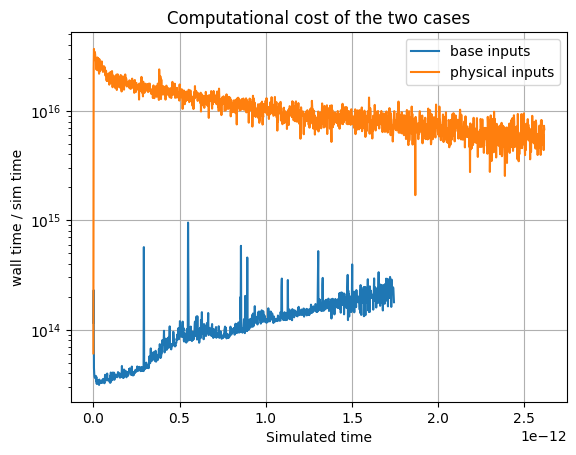

In [14]:
fig, ax = plt.subplots()

for name in casestore:
    ds = casestore[name]
    time = ds["t"]
    wtime =  wtimes[name]   # Wall time per timestep
    stime = time.diff("t")  # Simulated time per timestep
    stime = np.append(stime, stime[-1])
    
    ax.plot(time, wtime/stime, label = f"{name} inputs")
    
    print(f"{name} total runtime: {wtime.sum()/3600:.1f} hours on 120 cores")
    
ax.set_xlabel("Simulated time")
ax.set_ylabel("wall time / sim time")
ax.grid()
ax.set_yscale("log")
ax.legend()
ax.set_title("Computational cost of the two cases")
print()

# Post-processing: default inputs case

## Investigate convergence
- Presumably we can say we're converged once the fluctuation in outputs reaches a steady state

Text(0, 0.5, 'Normalised RMS')

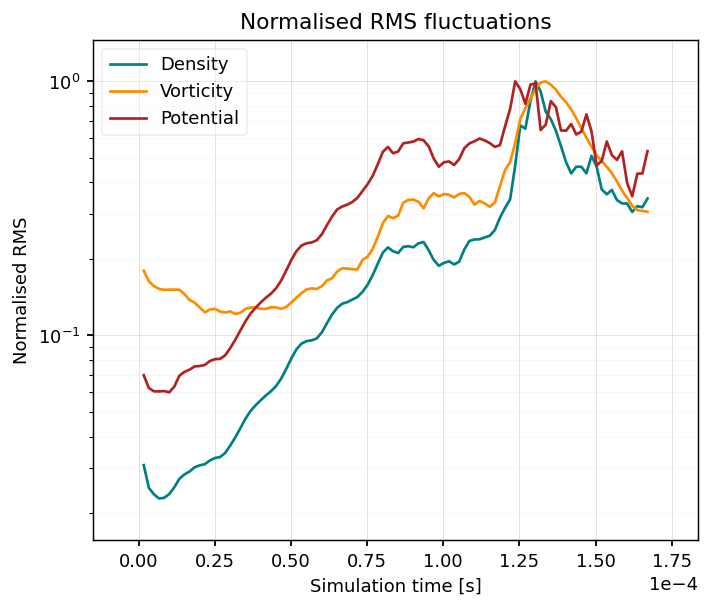

In [147]:
plt.close("all")
%matplotlib inline
### Calculate RMS of fluctuations

def get_scaled_rms(da):
    """
    Calculate root mean square of a DataArray
    """
    diff = da.diff("t")
    fractional_diff = diff 
    rms = np.sqrt((fractional_diff**2).mean(["x", "y", "z"]))
    return rms / rms.max()

### Plot
fig, ax = plt.subplots(dpi = 130)
get_scaled_rms(ds["n"]).plot(ax = ax, label = "Density", color = "teal")
get_scaled_rms(ds["vort"]).plot(ax = ax, label = "Vorticity", color = "darkorange")
get_scaled_rms(ds["phi"]).plot(ax = ax, label = "Potential", color = "firebrick")

ax.set_title("Normalised RMS fluctuations")
ax.grid(c = "k", alpha = 0.2)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Normalised RMS")

## Plots and animations

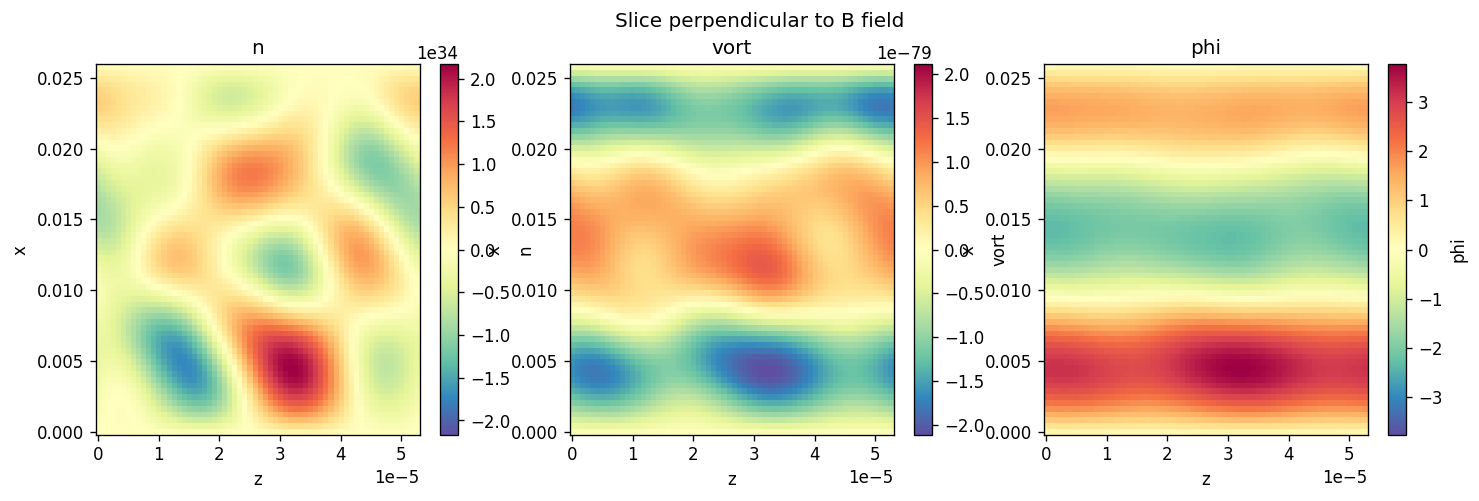

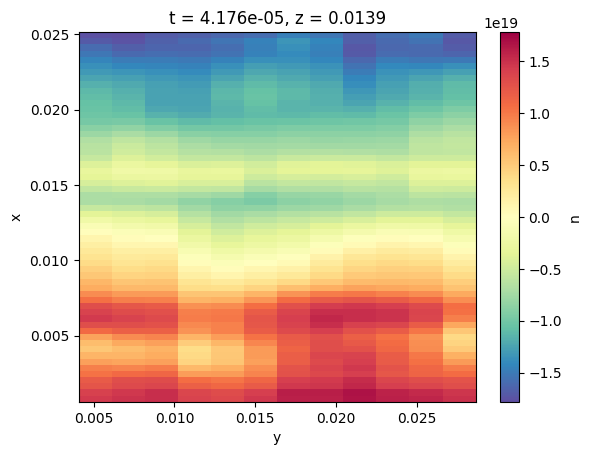

In [27]:
%matplotlib inline
plt.close("all")
ds = casestore["physical"]

fig, axes = plt.subplots(1, 3, figsize = (12,4), dpi = 120)
fig.suptitle("Slice perpendicular to B field")
fig.tight_layout()

for i, param in enumerate(["n", "vort", "phi"]):
    ds.isel(y=8, t=-1)[param].plot(ax = axes[i], cmap = "Spectral_r")
    axes[i].set_title(param)
    
fig, axes = plt.subplots(1, 3, figsize = (12,4), dpi = 120)
fig.suptitle("Slice parallel to B field (XY)")
fig.tight_layout()

for i, param in enumerate(["n", "vort", "phi"]):
    ds.isel(z=32, t=-1)[param].plot(ax = axes[i], cmap = "Spectral_r")
    axes[i].set_title(param)
    

n data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


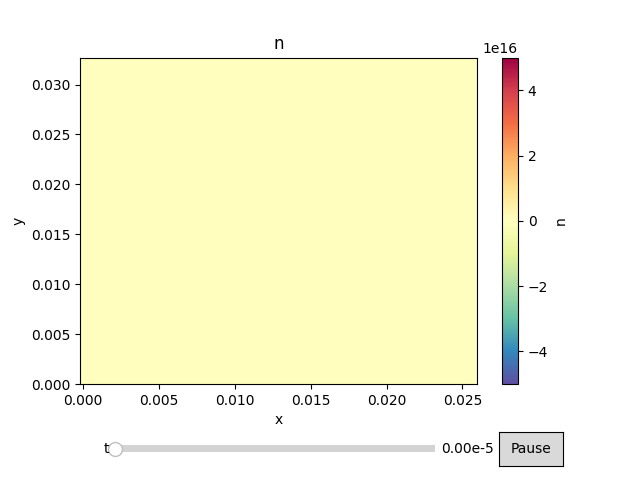

In [10]:
%matplotlib widget
plt.close("all")
plot_ds = casestore["physical"]
fig, ax = plt.subplots()
plot_ds.isel(y=8)["n"].bout.animate2D(fps = 30, cmap = "Spectral_r", ax = ax, 
                                    # save_as=r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\hw3d\hw3d_xz.gif"
                                    )
# ax.set_aspect("equal")

In [ ]:
%matplotlib inline
plt.close("all")
ds = ds_original.copy()

fig, axes = plt.subplots(1, 3, figsize = (12,4), dpi = 120)
fig.suptitle("Slice perpendicular to B field")
for i, param in enumerate(["n", "vort", "phi"]):
    ds.isel(y=8, t=-1)[param].plot(ax = axes[i], cmap = "Spectral_r")
    axes[i].set_title(param)
fig.tight_layout()
    
# fig, axes = plt.subplots(1, 3, figsize = (12,4), dpi = 120)
# fig.suptitle("Slice parallel to B field (XY)")
# for i, param in enumerate(["n", "vort", "phi"]):
#     ds.isel(z=32, t=-1)[param].plot(ax = axes[i], cmap = "Spectral_r")
#     axes[i].set_title(param)
# fig.tight_layout()

In [36]:
ds.dims

Frozen({'x': 64, 'y': 16, 't': 1001, 'z': 64})

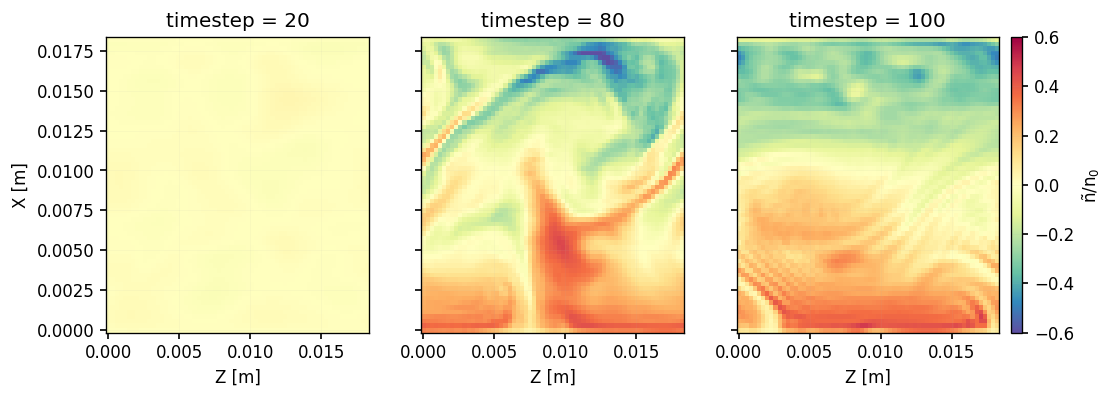

In [153]:
%matplotlib inline
plt.close("all")

fig, axes = plt.subplots(1, 3, figsize = (16*3/5,3.2), dpi = 120, sharey = True)

vmin = -0.60
vmax = 0.60
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

timeslices = [20,  80, 100]
for i, t in enumerate(timeslices):
    cbar = True if i == len(timeslices)-1 else False
    (ds.isel(y=8, t=t)["n"] / n0).plot(ax = axes[i], norm = norm, add_colorbar = False, cmap = "Spectral_r")
    # (ds.isel(y=8, t=t)["n"] / n0).plot(ax = axes[i], add_colorbar = True, cmap = "Spectral_r")
    
    if i != 0:
        axes[i].set_ylabel("")
        axes[i].tick_params(axis="y", which = "both", bottom = False, top = False)
    else:
        axes[i].set_ylabel("X [m]")
        
    axes[i].margins(0)
    axes[i].set_title(f"timestep = {t}")
    axes[i].set_xlabel("Z [m]")
    

# Add colorbar
cax = fig.add_axes([
                axes[-1].get_position().x1+0.01,
                axes[-1].get_position().y0,0.01,
                axes[-1].get_position().height])

sm = plt.cm.ScalarMappable(norm=norm, cmap = "Spectral_r")
cbar = plt.colorbar(mappable=sm, cax = cax, label = r"$\tilde{n} / n_{0}$")


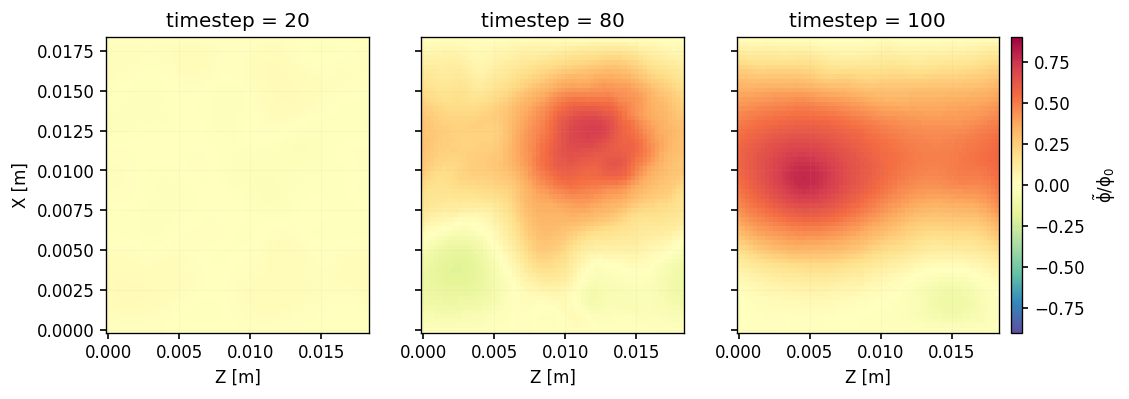

In [160]:
%matplotlib inline
plt.close("all")

fig, axes = plt.subplots(1, 3, figsize = (16*3/5,3.2), dpi = 120, sharey = True)

vmin = -0.90
vmax = 0.90
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

timeslices = [20,  80, 100]
for i, t in enumerate(timeslices):
    cbar = True if i == len(timeslices)-1 else False
    (ds.isel(y=8, t=t)["phi"] / T0).plot(ax = axes[i], norm = norm, add_colorbar = False, cmap = "Spectral_r")
    
    if i != 0:
        axes[i].set_ylabel("")
        axes[i].tick_params(axis="y", which = "both", bottom = False, top = False)
    else:
        axes[i].set_ylabel("X [m]")
        
    axes[i].margins(0)
    axes[i].set_title(f"timestep = {t}")
    axes[i].set_xlabel("Z [m]")
    

# Add colorbar
cax = fig.add_axes([
                axes[-1].get_position().x1+0.01,
                axes[-1].get_position().y0,0.01,
                axes[-1].get_position().height])

sm = plt.cm.ScalarMappable(norm=norm, cmap = "Spectral_r")
cbar = plt.colorbar(mappable=sm, cax = cax, label = r"$\tilde{\phi} / \phi_{0}$")
